In [1]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)
import os, sys
folder_name = 'Generation2' #@param {type:"string"}
os.chdir(os.getcwd()+'/drive/MyDrive/%s'%folder_name)

!pip -q install biopython ml-collections pytorch-lightning

from data.data_transforms import transform, prepare_features
from data.loader import RNA
# from data.build_dataset import open_data, RNAData
from config import model_config, TRACK_CODES
from data.generate_fake_example import generate_fake_example
# from MainTrunk_v2 import BaseTrunk
# from MainTrunk import BaseTrunk
from MainTrunk_v3 import BaseTrunk

import os, json, gzip, glob
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.utilities import rank_zero_info

from psutil import virtual_memory

seed_everything(42, workers=True)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

f = gzip.open('data/dataset.gz','rb')
loaded_rnas = json.loads(gzip.decompress(f.read()).decode("utf-8"))
all_data = {}
for dname, dat in loaded_rnas.items():
  all_data[dname] = {}
  for code,dictt in tqdm(dat.items()):
    all_data[dname][code] = RNA(**dictt)

Mounted at /content/drive


Global seed set to 42


Wed Sep 15 22:31:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

100%|██████████| 2273/2273 [00:00<00:00, 160458.69it/s]


```
alphafold:
  alphafolditeration:
    embeddings_and_evoformer:
      relpos
      seq_emb
      msa_emb
      (prev_emb)
      evoformer_iteration (48): {
        msa_row_attn_p_b
        col_glob_attnt
        msa_transition
        outer_prod_mean
        tri_mult_out
        tri_mult_in
        tri_attn_str
        tri_attn_end
        pair_transition
      }
    distogram_head
    (msa_head)
```

# Training the Evoformer & Embeddings

Let 1 epoch = 10K samples.
- Standard evoformer (8 layers)
- New distogram head
- Plot distograms as training progresses
- Progressively increase length of crops from 40 going up in 10's every 3 epochs 
- Save weights and record validation set loss.

# Training the Structure Module

- Add in prev_emb and recycling
- Add in structure module

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(6.215686423349219, 0.42021750741489955, 0.8691018808168193, 1.350726288804274)


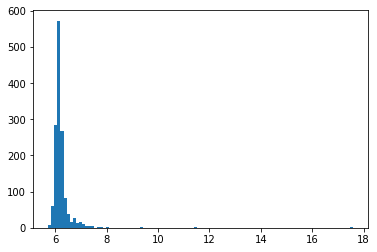

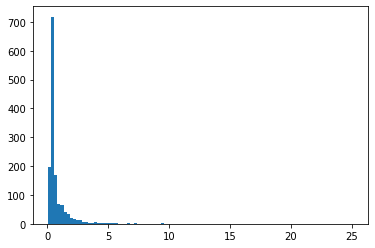

1414
[2273, 707, 845]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from data.loader import RNA_const

def filter_coord_data(all_data, min_len=7, min_mask_prop=0.4):
  ''' 
  Check coords are valid:
  - Some distances must be above the first break size
  - Some distances must be below the last break size
  - Unmasked coords must be above min size

  '''
  names = ['train','validation','hold-out']

  def compute_average_origin_bond_length(data):
    lengths = {}
    for c, d in data.items():
      xm = np.array(data[c].atom_mask)[:,RNA_const.basis[0]]
      X = np.array(data[c].atom_positions)[xm==1,RNA_const.basis[0]]
      lns = ((X[1:]-X[:-1])**2).sum(-1)**0.5
      contig = len(max(bytes(list(xm.astype(int))).split(b'\0')))
      lengths[c] = (lns, len(X), len(xm), contig)
    return lengths
  
  a,b,c = [compute_average_origin_bond_length(all_data[n]) for n in names]
  all_ = {**a,**b,**c}
  
  # filter out the infinity ones
  all_ = {k:(lns, l, m, ct) for k,(lns, l, m, ct) in all_.items() if np.mean(lns) < float('inf')}

  # filter the too short ones
  all_ = {k:(lns, l, m, ct) for k,(lns, l, m, ct) in all_.items() if m > min_len}

  # filter ones which have too little valid points
  all_ = {k:(lns, l, m, ct) for k,(lns, l, m, ct) in all_.items() if m > l*min_mask_prop}

  av = [(a, np.mean(b), np.std(b)) for a,(b,*_) in all_.items()]
  codes, average_lens, stdevs = list(zip(*av))

  print((np.mean(average_lens), np.std(average_lens), np.mean(stdevs), np.std(stdevs)))
  plt.hist(average_lens, bins=100)
  plt.show()
  plt.hist(stdevs, bins=100)
  plt.show()

  return set(all_.keys())
  
good_examples = filter_coord_data(all_data, min_len=24)

print(len(good_examples))
print([len(all_data[n]) for n in ['train','validation','hold-out']])

In [3]:
def plot_data(w,h):
  fig = plt.figure(figsize=(w*10, h*10))
  for k,(i,j) in enumerate([(a,b) for a in range(w) for b in range(h)]):
    if k<len(codes):
      code = codes[k]
      X = np.array(all_data['train'][code].atom_positions)[:,RNA_const.basis[0]]
      X = X[np.array(all_data['train'][code].atom_mask)[:,RNA_const.basis[0]]==1]
      ax = fig.add_subplot(h, w, k+1, projection='3d')
      ax.plot(*X.T, 'o-', lw=0.6)
      ax.axis('off')
      ax.set_title(code, fontsize=30)
  plt.tight_layout()
  plt.show()

def conditions(c):
  xm = np.array(all_data['train'][c].atom_mask)[:,RNA_const.basis[0]]
  return xm.sum() >= 8

def disply_plts():
  codes = list(all_data['train'].keys())
  codes = list(filter(conditions, codes))
  w, h = 14, 40
  plot_data(w,h)

In [4]:
class UniformLengthSampler:
  def __init__(self, lengths, crop_size, min_clip=20, short_penalty=0.1):
    self.w = torch.zeros(len(lengths))
    for i,l in enumerate(lengths):
      resampling_score = max(l, crop_size) / crop_size #____/
      # short sequences are easier and don't make best use of parallelism
      short = (1 - short_penalty) + short_penalty * min(min_clip, l) / min_clip
      self.w[i] = short * resampling_score
    
  def __call__(self, _):
    return torch.multinomial(self.w, 1).item()

class RNAData(Dataset):
  # res = ['1.5A','2.0A','2.5A','3.0A','3.5A','4.0A','20.0A','above 20']
  def __init__(self, 
      data, config, prepare_features, transform, device='cpu', filter_msa=None, 
      length=None, generator='uniform', filter_res=True, 
      acceptable = {'4.0A', '3.5A', '3.0A', '2.5A', '2.0A', '1.5A'}
    ):
    min_len = 8
    kw = {'rna':True, 'basis':("C4'",'P','P'), 'basis_shifts':(0,1,0)}
    data = {k:d for k,d in data.items() if k in good_examples}

    # go through data and filter MSA if e-val is to high
    if filter_msa is not None:
      msa_evals = json.loads(open('data/msa_evals.json','r').read())
      get_rid = {k for k, v in msa_evals.items() if v>filter_msa and k in data}
      print('filtered %d msa to %d msa with e-values better than %s'%(
          len(msa_evals), len(msa_evals)-len(get_rid), str(filter_msa)))
      for k in get_rid:
        d = data[k].__dict__
        d['msa'] = [d['sequence']]
        data[k] = RNA(**d)
    
    if filter_res:
      resolution_bins = json.loads(open('data/resolution_partition.json', 'r').read())
      cs = []
      for a in acceptable: cs += resolution_bins[a]
      cs = set(cs)
      data = {k:d_ for k,d_ in data.items() if k in cs}
      
    self.data = {k:prepare_features(v, device, **kw) for k,v in tqdm(data.items()) if v.num_res > min_len}
    # self.data = {k:{f:t[0] for f,t in feat.items()} for k, feat in self.data}
    self.ix2key = [k for k in self.data]
    self.config = config.data
    self.transform = transform
    self.ln = length if length is not None else len(self.ix2key)

    self.get = {
      'uniform': lambda i: torch.randint(0,len(self.ix2key), (1,)).item(),
      'deterministic': lambda i:i,
      'uniform-length': UniformLengthSampler(
          [self.data[k][0]['seq_length'][0].item() for k in self.ix2key], 
          self.config.training.constant.crop_size)
    }[generator]

  def __len__(self):
    return self.ln
  
  def __getitem__(self, idx):
    code = self.ix2key[self.get(idx)]
    batch = self.transform(*self.data[code], self.config, 1, 0, rna=True)
    # batch = {f:t[0] for f,t in batch.items()}# only one forward pass
    batch['code'] = code
    return batch
    
def collate_fn(data):
  # it's already batched... so only use the first item (only item)
  return data[0]

In [5]:
def instantiateAF(config, device, args=[]):
  random_batch = generate_fake_example(0)
  random_batch = {f:t[0] for f,t in random_batch.items()}

  af = BaseTrunk(config, *args)

  _ = af({k:v.to(device) for k,v in random_batch.items()})
  del _
  return af

def standard_init(config, device, TRACK_CODES, num_epochs, n_examples, checkpoint_version=None, args=[]):
  af = instantiateAF(config, device, args=args)
  af.eval()
  af.is_training = True
  af.compute_loss = True

  af.set_optim_config(opt_cfg, num_epochs, n_examples)
  af.track_codes(TRACK_CODES)
  af = af.to(device)

  if checkpoint_version is not None:
    print('loading from checkpoint: '+str(checkpoint_version))
    path = 'lightning_logs/version_%s/checkpoints'%checkpoint_version
    [path] = list(glob.glob(path+'/*.ckpt'))
    af.load_state_dict(torch.load(path)["state_dict"])
    print('done')

  return af

def augment_tranfer(
    config, device, TRACK_CODES, num_epochs, n_examples, checkpoint_version=None, args=[],
  ):
  ''' assumes that the new version has all of the previous parameters '''
  af = instantiateAF(config, device, args=args)
  af.eval()
  af.is_training = True
  af.compute_loss = True

  af.set_optim_config(opt_cfg, num_epochs, n_examples)
  af.track_codes(TRACK_CODES)
  af = af.to(device)

  if checkpoint_version is not None:
    print('loading from checkpoint: '+str(checkpoint_version))
    path = 'lightning_logs/version_%s/checkpoints'%checkpoint_version
    [path] = list(glob.glob(path+'/*.ckpt'))
    state = torch.load(path)["state_dict"]

    # go through all parameters
    af_ps = {npr for npr, p in af.named_parameters()}
    sd = af.state_dict()
    for npr, p in state.items():
      if npr in af_ps:
        sd[npr].data = p.data
    af.load_state_dict(sd)
  
    success, fail = [], []
    for npr, p in state.items():
      if npr in af.state_dict():
        diff = torch.abs(af.state_dict()[npr].data - p.data)
        assert diff.max() < 1e-5, 'didn\'t transfer correctly'
        success.append(npr)
      else:
        fail.append(npr)
    print('SUCCESSFULLY TRANSFERRED:')
    print(success)
    print('FAILED TO TRANSFER:')
    print(fail)
    print('COULDN\'T FIND: ')
    print(af_ps - set(success) - set(fail))

  return af

In [6]:
opt_cfg = {
  'optim_type' : 'AdamW',
  'optim_groups': {
    'default':{
      'lr':9e-5,
      'weight_decay':0,
    }
  },
  'scheduler': {
    'num_call_per_epoch':300,
    'class':'torch.optim.lr_scheduler.LambdaLR',
    'kwargs':"{'lr_lambda':[lambda t: 0.55 + 0.45*np.cos(40*t)]}"
  }
}

filtered 875 msa to 803 msa with e-values better than 1e-06


100%|██████████| 653/653 [00:46<00:00, 13.98it/s]


filtered 875 msa to 846 msa with e-values better than 1e-06


100%|██████████| 89/89 [00:31<00:00,  2.79it/s]


filtered 875 msa to 865 msa with e-values better than 1e-06


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


scheduler found
scheduler calling at 33


''

loading from checkpoint: 6
done


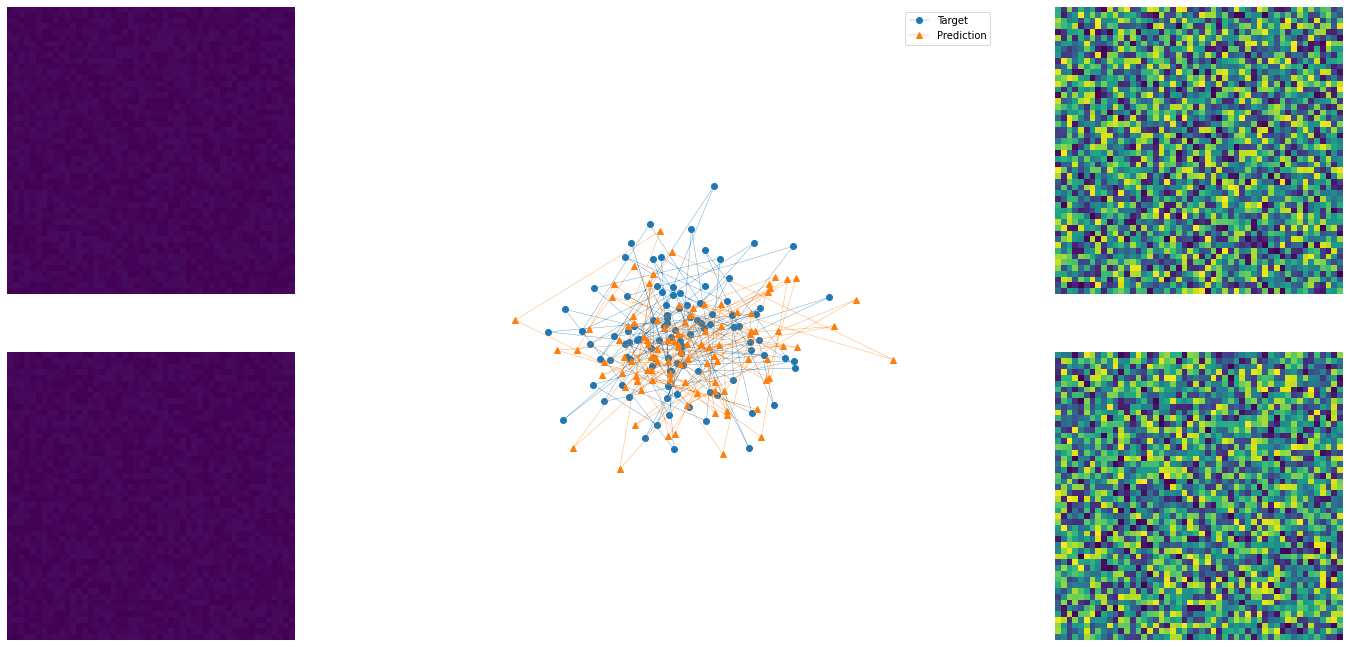

In [7]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

config = model_config('model_5')
config.model.embeddings_and_evoformer.evoformer_num_block = 12
config.model.embeddings_and_evoformer.extra_msa_stack_num_block = 2
# config.model.heads.structure_module.num_layer = FOLD_LAYERS
config.data.training.constant.crop_size = 120
config.model.global_config.device = device

num_epochs = 18

data_args = (config, prepare_features, transform, device, 1e-6)
train_gen = RNAData(all_data['train'], *data_args, length=10000, generator='uniform-length')
valid_gen = RNAData(all_data['validation'], *data_args, generator='deterministic')
test_gen = RNAData(all_data['hold-out'], *data_args, generator='deterministic')


# orig_disto = False
args = [{'delta_disto':0.5, 'original_disto':0.0, 'structure_module':1.5}]
ver = 6

# del BaseTrunk, af
# from MainTrunk_v3 import BaseTrunk
af = standard_init(
  config, device, TRACK_CODES, num_epochs, len(train_gen), checkpoint_version=ver, args=args
)

# af = augment_tranfer(# when the model is looading a subset of parameters
#   config, device, TRACK_CODES, num_epochs, len(train_gen), checkpoint_version=ver, args=args
# )

# for k in af.groups:
#   print('-'*100)
#   print(k)
#   print(af.groups[k])
#   print()

# only_end_evo = False
# if only_end_evo:
#   ei = 'evoformer_iteration'
#   for n,p in af.named_parameters():
#     train_evo = False
#     if ei in n:
#       i = int(n[n.index(ei)+len(ei)+1:].split('.')[0])
#       train_evo = i >= 8
#     p.requires_grad = train_evo# or 'distogram' in n 

# if orig_disto:
#   for n,p in af.named_parameters():
#     p.requires_grad = 'original_distogram_head' in n

# for n,p in af.named_parameters():
#   print(n+', '+str(p.requires_grad))

In [8]:
data_conf = {'collate_fn':collate_fn, 'shuffle':True, 'batch_size':1,}
train_loader = DataLoader(train_gen, **data_conf)
data_conf['shuffle'] = False
val_loader = DataLoader(valid_gen, **data_conf)
test_loader = DataLoader(test_gen, **data_conf)

train_conf = {
    'auto_lr_find':False,
    'progress_bar_refresh_rate':1, 
    'max_epochs':num_epochs, 
    'gradient_clip_val':0.1, 
    # 'plugins':DeepSpeedPlugin(
    #     stage=3,
    #     cpu_offload=True,  # Enable CPU Offloading
    #     partition_activations=True,
    #     # cpu_checkpointing=True,  # (Optional) offload activations to CPU
    # ),
}
if torch.cuda.is_available(): train_conf['gpus'] = 1

trainer = Trainer(**train_conf)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                   | Params
------------------------------------------------------------
0 | trunk            | EmbeddingsAndEvoformer | 23.5 M
1 | distogram_head   | DistogramPostsHead     | 258   
2 | structure_module | StructureModule        | 1.9 M 
------------------------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.429   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Global seed set to 42


Training: -1it [00:00, ?it/s]

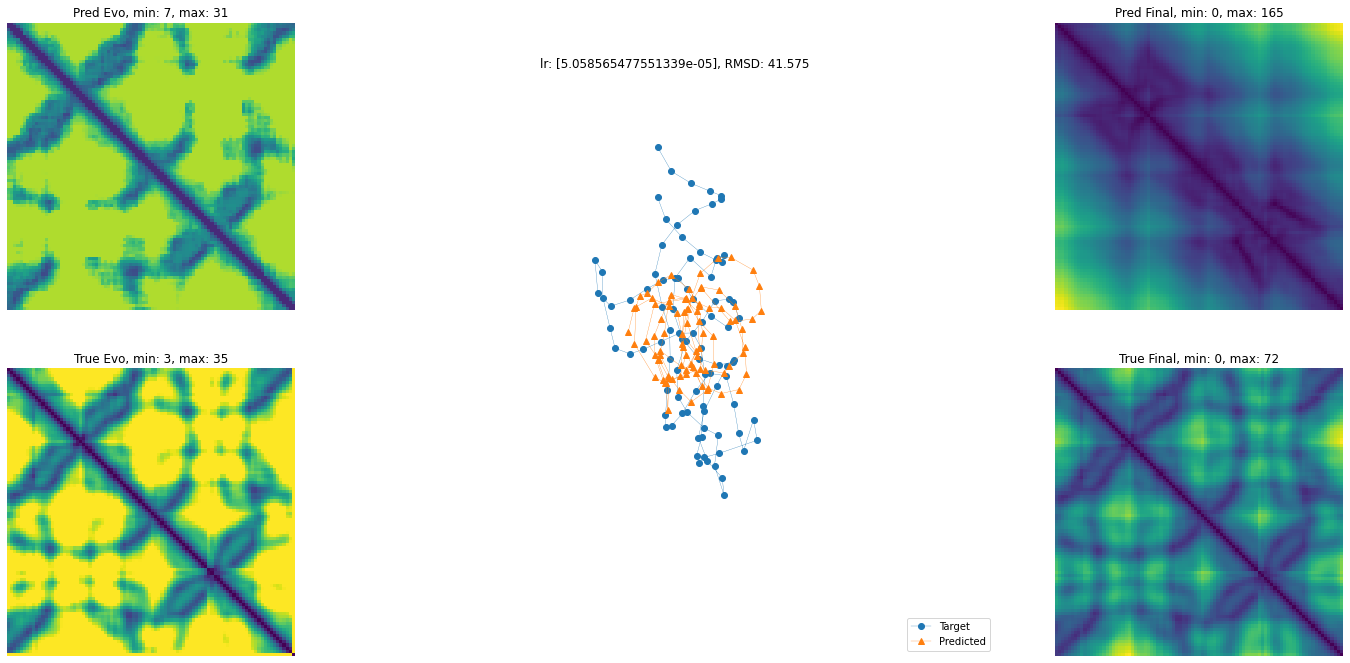

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradien

Validating: 0it [00:00, ?it/s]

In [9]:
trainer.fit(af, train_loader, val_loader)

In [10]:
trainer.test(test_dataloaders=test_loader, ckpt_path="best")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 19.997411727905273}
--------------------------------------------------------------------------------


[{'test_loss': 19.997411727905273}]